In [1]:
import yfinance as yf
import pandas as pd
from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import numpy as np


# Set up End and Start times for data grab
end = datetime.now()
start = datetime(end.year - 10, end.month, end.day)

# List of top 10 Nifty 50 stocks
nifty_stocks = ['RELIANCE.NS', 'HDFCBANK.NS', 'INFY.NS', 'ICICIBANK.NS', 
                'TCS.NS', 'HINDUNILVR.NS', 'KOTAKBANK.NS', 'LT.NS', 'ITC.NS', 'BHARTIARTL.NS']

# List of top 10 US stocks
us_stocks = ['AAPL', 'MSFT', 'AMZN', 'GOOGL', 'META', 'TSLA', 'NVDA','JNJ', 'JPM']

# Combine both lists
all_stocks = nifty_stocks + us_stocks

# Download data
stock_data = {}
for stock in all_stocks:
    stock_data[stock] = yf.download(stock, start=start, end=end)

# Concatenate all the DataFrames into a single DataFrame
df = pd.concat(stock_data.values(), keys=stock_data.keys(), axis=0)

# Display the first few rows
df.head()


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

Open        High         Low       Close  \
            Date                                                         
RELIANCE.NS 2014-08-20  462.195190  465.601074  455.040527  456.412018   
            2014-08-21  457.166351  458.995026  452.640411  454.926239   
            2014-08-22  457.212067  460.366516  455.017670  456.389160   
            2014-08-25  457.166351  461.052277  454.171906  455.246246   
            2014-08-26  455.337677  455.772003  449.394531  454.126190   

                         Adj Close   Volume  
            Date                             
RELIANCE.NS 2014-08-20  428.976013  6511039  
            2014-08-21  427.579529  8224610  
            2014-08-22  428.954529  4285807  
            2014-08-25  427.880310  3727616  
            2014-08-26  426.827606  4774104

In [2]:
pip install 

Note: you may need to restart the kernel to use updated packages.


ERROR: You must give at least one requirement to install (see "pip help install")


In [3]:
# Define investment horizons
investment_horizons = ['intraday', 'short_term', 'mid_term', 'long_term']

# Stock recommendation structure
recommendations = {
    'nifty': {'intraday': [], 'short_term': [], 'mid_term': [], 'long_term': []},
    'us': {'intraday': [], 'short_term': [], 'mid_term': [], 'long_term': []}
}


def preprocess_data(df):
    # Calculate daily returns
    df['Returns'] = df['Adj Close'].pct_change()
    
    # Create moving averages as features
    df['MA_5'] = df['Adj Close'].rolling(window=5).mean()
    df['MA_10'] = df['Adj Close'].rolling(window=10).mean()
    
    # Drop NaN values resulting from rolling calculations
    df.dropna(inplace=True)
    
    return df


# Function to train a model and make predictions
def train_predict(stock, df, horizon):
    # Feature Engineering: Create moving averages and other features
    df['MA_5'] = df['Adj Close'].rolling(window=5).mean()
    df['MA_10'] = df['Adj Close'].rolling(window=10).mean()
    df.dropna(inplace=True)
    
    if df.empty or len(df) < 2:  # Check if DataFrame is empty or has too few rows
        print(f"Not enough data for stock {stock} for {horizon} prediction.")
        return None
    
    # Define target variable (next day price for intraday, next month price for short-term, etc.)
    if horizon == 'intraday':
        df['Target'] = df['Adj Close'].shift(-1)
    elif horizon == 'short_term':
        df['Target'] = df['Adj Close'].shift(-20)  # Approx. 1 month ahead
    elif horizon == 'mid_term':
        df['Target'] = df['Adj Close'].shift(-60)  # Approx. 3 months ahead
    elif horizon == 'long_term':
        df['Target'] = df['Adj Close'].shift(-120)  # Approx. 6 months ahead
    
    df.dropna(inplace=True)
    
    if df.empty or len(df) < 2:  # Check if DataFrame is empty or has too few rows after shifting target
        print(f"Not enough data for stock {stock} after target shift for {horizon} prediction.")
        return None
    
    # Features and target
    X = df[['Adj Close', 'MA_5', 'MA_10']]
    y = df['Target']
    
    # Split into train and test
    try:
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    except ValueError as e:
        print(f"Error in train_test_split for stock {stock}: {e}")
        return None
    
    # Train model (Random Forest for simplicity)
    model = RandomForestRegressor(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)
    
    # Make predictions
    predictions = model.predict(X_test)
    
    # Evaluate the model (for reference)
    rmse = np.sqrt(mean_squared_error(y_test, predictions))
    print(f'RMSE for {stock} ({horizon}): {rmse}')
    
    # Return the model for prediction
    return model

# Predict and recommend stocks for each horizon
for stock in all_stocks:
    # Preprocess the data for each stock
    df_stock = stock_data[stock].copy()
    df_stock = preprocess_data(df_stock)
    
    for horizon in investment_horizons:
        # Train and predict
        model = train_predict(stock, df_stock, horizon)
        
        if model is not None:
            # Get the latest features for prediction
            latest_features = df_stock[['Adj Close', 'MA_5', 'MA_10']].iloc[-1].values.reshape(1, -3)
        
            # Predict future price
            future_price = model.predict(latest_features)[0]
        
            # Determine if the stock is a good investment (e.g., based on predicted price change)
            if future_price > df_stock['Adj Close'].iloc[-1]:
                if stock in nifty_stocks:
                    recommendations['nifty'][horizon].append(stock)
                else:
                    recommendations['us'][horizon].append(stock)

# Display recommendations
for region, recs in recommendations.items():
    print(f"\n{region.upper()} Stock Recommendations:")
    for horizon, stocks in recs.items():
        print(f"{horizon.capitalize()} Recommendation: {stocks[:3]}")  # Top 3 recommendations


RMSE for RELIANCE.NS (intraday): 27.3491976527694


C:\Users\swamy\anaconda3\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


RMSE for RELIANCE.NS (short_term): 86.34052097207204


C:\Users\swamy\anaconda3\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


RMSE for RELIANCE.NS (mid_term): 155.8461169827194


C:\Users\swamy\anaconda3\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


RMSE for RELIANCE.NS (long_term): 153.5683161862755


C:\Users\swamy\anaconda3\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


RMSE for HDFCBANK.NS (intraday): 17.44346994142814


C:\Users\swamy\anaconda3\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


RMSE for HDFCBANK.NS (short_term): 57.45216925786692


C:\Users\swamy\anaconda3\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


RMSE for HDFCBANK.NS (mid_term): 79.15870521783326


C:\Users\swamy\anaconda3\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


RMSE for HDFCBANK.NS (long_term): 99.01726998970602


C:\Users\swamy\anaconda3\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


RMSE for INFY.NS (intraday): 15.979248062833149


C:\Users\swamy\anaconda3\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


RMSE for INFY.NS (short_term): 59.33708809559959


C:\Users\swamy\anaconda3\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


RMSE for INFY.NS (mid_term): 88.14645153923065


C:\Users\swamy\anaconda3\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


RMSE for INFY.NS (long_term): 100.18735894497884


C:\Users\swamy\anaconda3\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


RMSE for ICICIBANK.NS (intraday): 8.660896353799714


C:\Users\swamy\anaconda3\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


RMSE for ICICIBANK.NS (short_term): 31.077464095626556


C:\Users\swamy\anaconda3\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


RMSE for ICICIBANK.NS (mid_term): 41.93677451155868


C:\Users\swamy\anaconda3\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


RMSE for ICICIBANK.NS (long_term): 56.99123568363257


C:\Users\swamy\anaconda3\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


RMSE for TCS.NS (intraday): 36.576114201964835


C:\Users\swamy\anaconda3\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


RMSE for TCS.NS (short_term): 109.65983792101179


C:\Users\swamy\anaconda3\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


RMSE for TCS.NS (mid_term): 159.3112256915893


C:\Users\swamy\anaconda3\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


RMSE for TCS.NS (long_term): 192.30773154817578


C:\Users\swamy\anaconda3\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


RMSE for HINDUNILVR.NS (intraday): 27.279214176389505


C:\Users\swamy\anaconda3\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


RMSE for HINDUNILVR.NS (short_term): 102.24164571508588


C:\Users\swamy\anaconda3\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


RMSE for HINDUNILVR.NS (mid_term): 120.51229459790876


C:\Users\swamy\anaconda3\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


RMSE for HINDUNILVR.NS (long_term): 129.51422378730595


C:\Users\swamy\anaconda3\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


RMSE for KOTAKBANK.NS (intraday): 24.594361044102264


C:\Users\swamy\anaconda3\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


RMSE for KOTAKBANK.NS (short_term): 90.3417875933979


C:\Users\swamy\anaconda3\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


RMSE for KOTAKBANK.NS (mid_term): 119.92920463171767


C:\Users\swamy\anaconda3\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


RMSE for KOTAKBANK.NS (long_term): 132.27205468776154


C:\Users\swamy\anaconda3\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


RMSE for LT.NS (intraday): 24.077038456713858


C:\Users\swamy\anaconda3\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


RMSE for LT.NS (short_term): 92.82675789857984


C:\Users\swamy\anaconda3\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


RMSE for LT.NS (mid_term): 133.13040905168154


C:\Users\swamy\anaconda3\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


RMSE for LT.NS (long_term): 204.23417205055742


C:\Users\swamy\anaconda3\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


RMSE for ITC.NS (intraday): 3.684076220621092


C:\Users\swamy\anaconda3\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


RMSE for ITC.NS (short_term): 13.508553903887684


C:\Users\swamy\anaconda3\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


RMSE for ITC.NS (mid_term): 20.738013019332477


C:\Users\swamy\anaconda3\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


RMSE for ITC.NS (long_term): 30.97413426147083


C:\Users\swamy\anaconda3\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


RMSE for BHARTIARTL.NS (intraday): 10.102497359814215


C:\Users\swamy\anaconda3\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


RMSE for BHARTIARTL.NS (short_term): 31.40174366416358


C:\Users\swamy\anaconda3\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


RMSE for BHARTIARTL.NS (mid_term): 46.387888031891514


C:\Users\swamy\anaconda3\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


RMSE for BHARTIARTL.NS (long_term): 65.66788243060874


C:\Users\swamy\anaconda3\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


RMSE for AAPL (intraday): 2.106394182055474


C:\Users\swamy\anaconda3\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


RMSE for AAPL (short_term): 7.1091260535372145


C:\Users\swamy\anaconda3\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


RMSE for AAPL (mid_term): 11.362151020914073


C:\Users\swamy\anaconda3\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


RMSE for AAPL (long_term): 11.174644809384167


C:\Users\swamy\anaconda3\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


RMSE for MSFT (intraday): 4.04650870778087


C:\Users\swamy\anaconda3\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


RMSE for MSFT (short_term): 11.188367533018287


C:\Users\swamy\anaconda3\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


RMSE for MSFT (mid_term): 18.573504270435883


C:\Users\swamy\anaconda3\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


RMSE for MSFT (long_term): 19.893282513257105


C:\Users\swamy\anaconda3\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


RMSE for AMZN (intraday): 2.8039909953252278


C:\Users\swamy\anaconda3\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


RMSE for AMZN (short_term): 8.383473134885755


C:\Users\swamy\anaconda3\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


RMSE for AMZN (mid_term): 15.00029038793356


C:\Users\swamy\anaconda3\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


RMSE for AMZN (long_term): 17.384682139708627


C:\Users\swamy\anaconda3\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


RMSE for GOOGL (intraday): 2.1369859412983225


C:\Users\swamy\anaconda3\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


RMSE for GOOGL (short_term): 5.566177537582235


C:\Users\swamy\anaconda3\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


RMSE for GOOGL (mid_term): 9.33865114595445


C:\Users\swamy\anaconda3\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


RMSE for GOOGL (long_term): 9.601857492653735


C:\Users\swamy\anaconda3\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


RMSE for META (intraday): 5.865089010393256


C:\Users\swamy\anaconda3\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


RMSE for META (short_term): 18.852155204033348


C:\Users\swamy\anaconda3\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


RMSE for META (mid_term): 38.73891099722477


C:\Users\swamy\anaconda3\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


RMSE for META (long_term): 45.624589393023044


C:\Users\swamy\anaconda3\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


RMSE for TSLA (intraday): 6.896709791511071


C:\Users\swamy\anaconda3\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


RMSE for TSLA (short_term): 23.91923023558519


C:\Users\swamy\anaconda3\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


RMSE for TSLA (mid_term): 31.184664048786072


C:\Users\swamy\anaconda3\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


RMSE for TSLA (long_term): 32.55400521398054


C:\Users\swamy\anaconda3\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


RMSE for NVDA (intraday): 1.1585640758061315


C:\Users\swamy\anaconda3\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


RMSE for NVDA (short_term): 4.6398880185983025


C:\Users\swamy\anaconda3\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


RMSE for NVDA (mid_term): 3.3713777634451585


C:\Users\swamy\anaconda3\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


RMSE for NVDA (long_term): 5.918909723185917


C:\Users\swamy\anaconda3\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


RMSE for JNJ (intraday): 1.6303977475571103


C:\Users\swamy\anaconda3\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


RMSE for JNJ (short_term): 5.187463460587067


C:\Users\swamy\anaconda3\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


RMSE for JNJ (mid_term): 6.161779079992798


C:\Users\swamy\anaconda3\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


RMSE for JNJ (long_term): 6.394292060161145


C:\Users\swamy\anaconda3\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


RMSE for JPM (intraday): 1.9831712497747505


C:\Users\swamy\anaconda3\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


RMSE for JPM (short_term): 6.45496927873346


C:\Users\swamy\anaconda3\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


RMSE for JPM (mid_term): 9.14242804632969


C:\Users\swamy\anaconda3\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


RMSE for JPM (long_term): 15.301034818296223

NIFTY Stock Recommendations:
Intraday Recommendation: ['RELIANCE.NS', 'HDFCBANK.NS', 'TCS.NS']
Short_term Recommendation: ['INFY.NS', 'ITC.NS', 'BHARTIARTL.NS']
Mid_term Recommendation: ['RELIANCE.NS', 'HDFCBANK.NS', 'INFY.NS']
Long_term Recommendation: ['RELIANCE.NS', 'INFY.NS', 'ICICIBANK.NS']

US Stock Recommendations:
Intraday Recommendation: ['AAPL', 'MSFT', 'GOOGL']
Short_term Recommendation: ['NVDA', 'JPM']
Mid_term Recommendation: ['AAPL', 'MSFT', 'GOOGL']
Long_term Recommendation: ['MSFT', 'AMZN', 'GOOGL']


C:\Users\swamy\anaconda3\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Closing Price:

The closing price is the last price at which the stock is traded during the regular trading day. A stock’s closing price is the standard benchmark used by investors to track its performance over time.

C:\Users\swamy\AppData\Local\Temp\ipykernel_28564\986999599.py:12: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab20', len(tech_list))


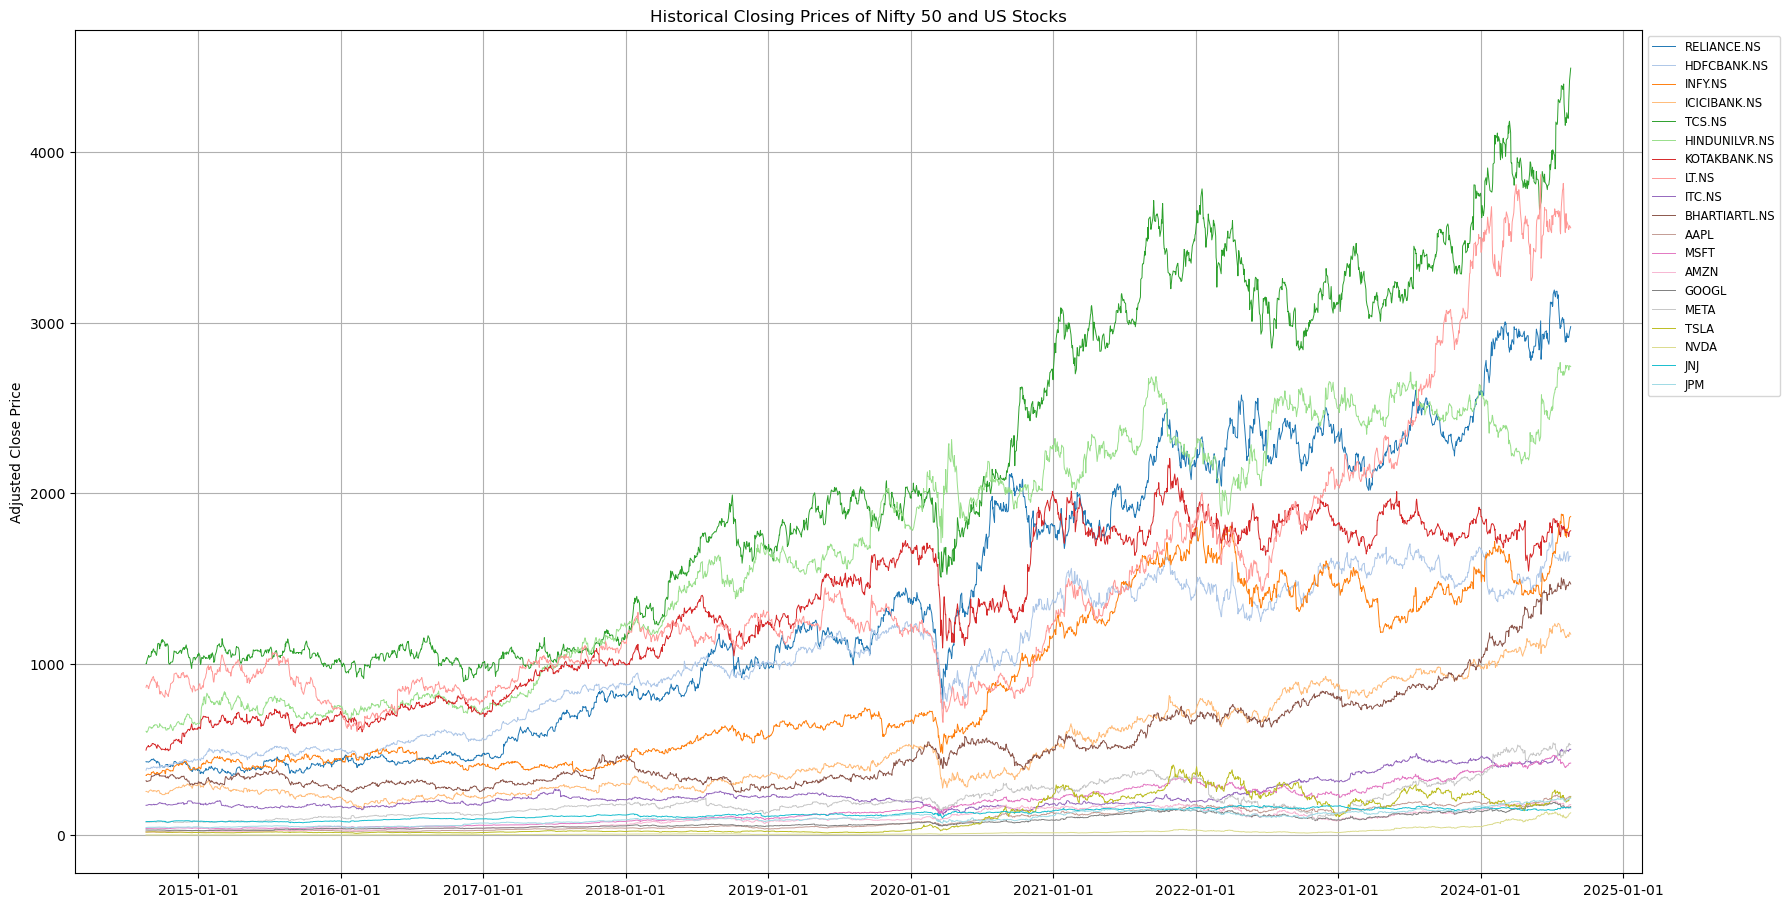

In [4]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# List of stock tickers and their corresponding labels for the plot
tech_list = nifty_stocks + us_stocks

# Let's see a historical view of the closing price
plt.figure(figsize=(18, 12))
plt.subplots_adjust(top=1.25, bottom=1.2)

# Use a color map with 20 distinct colors
colors = plt.cm.get_cmap('tab20', len(tech_list))

# Iterate over all stocks and plot their adjusted closing prices
for i, stock in enumerate(tech_list):
    stock_df = df.loc[stock]
    plt.plot(stock_df.index, stock_df['Adj Close'], label=stock, color=colors(i), linewidth=0.7)

plt.ylabel('Adjusted Close Price')
plt.title("Historical Closing Prices of Nifty 50 and US Stocks")

# Add a legend outside the plot
plt.legend(loc='upper left', bbox_to_anchor=(1, 1), fontsize='small')

# Format x-axis for dates
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.YearLocator())

plt.grid(True)
plt.tight_layout()

# Show the plot
plt.show()


Volume of Sales:

Volume is the amount of an asset or security that changes hands over some period of time, often over the course of a day. For instance, the stock trading volume would refer to the number of shares of security traded between its daily open and close. Trading volume, and changes to volume over the course of time, are important inputs for technical traders.

C:\Users\swamy\AppData\Local\Temp\ipykernel_28564\3555721168.py:9: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab20', len(tech_list))


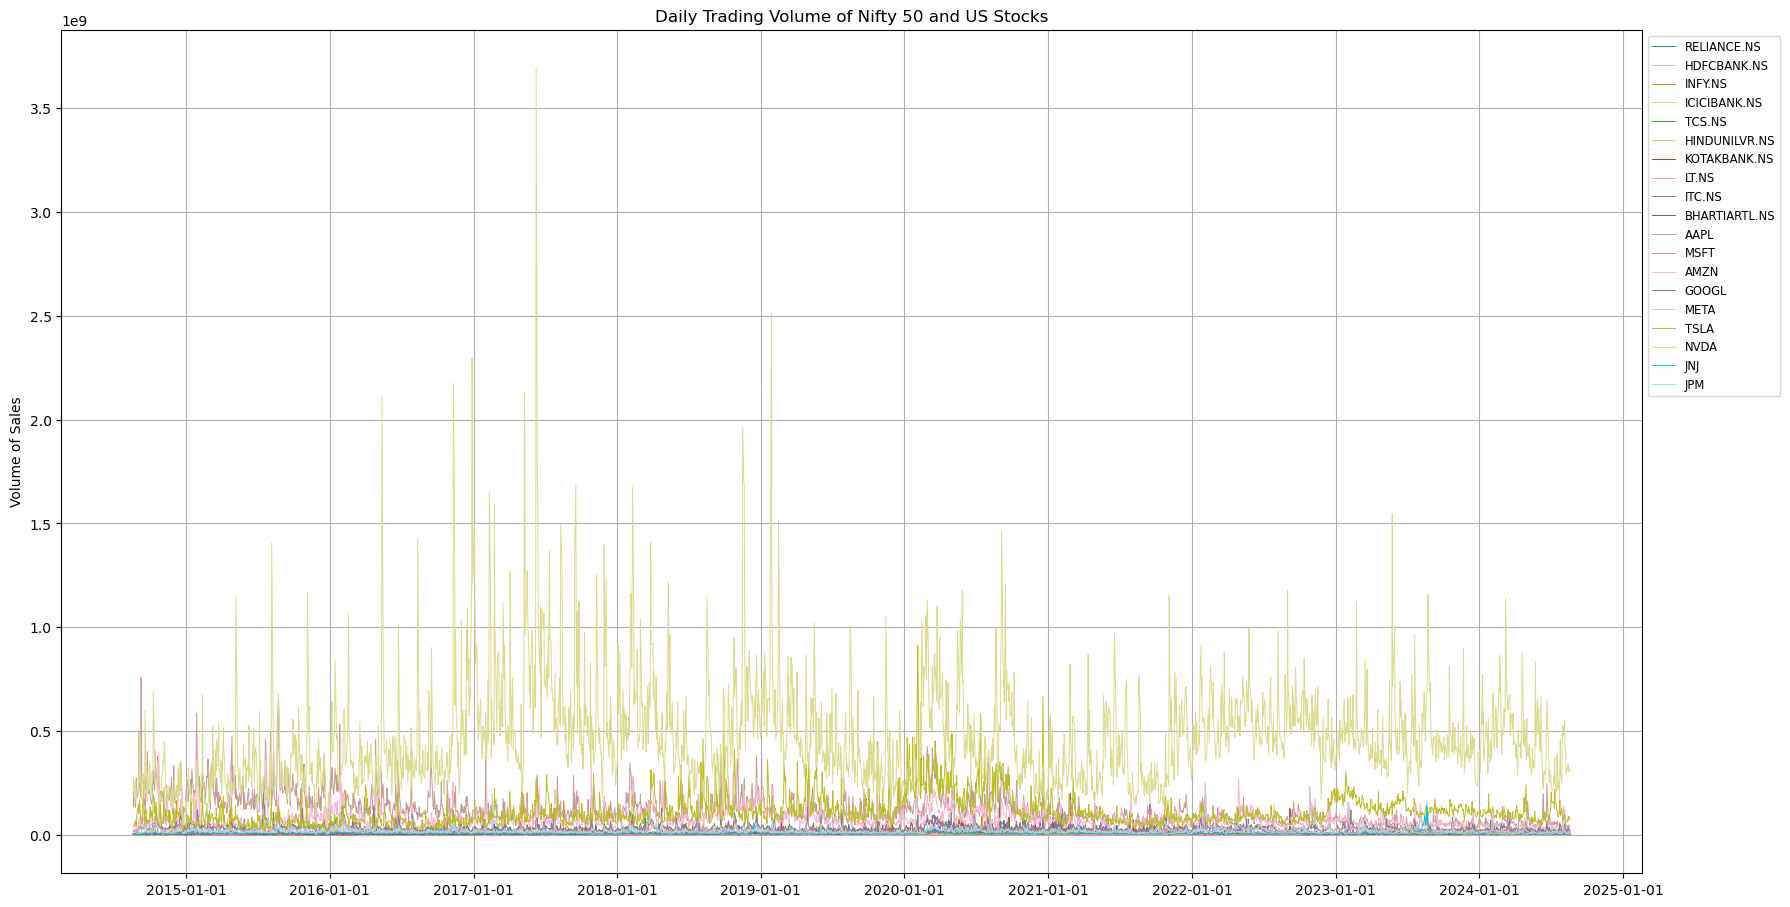

In [5]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Let's see a historical view of the volume of sales (trading volume)
plt.figure(figsize=(18, 12))
plt.subplots_adjust(top=1.25, bottom=1.2)

# Use a color map with 20 distinct colors
colors = plt.cm.get_cmap('tab20', len(tech_list))

# Iterate over all stocks and plot their trading volumes
for i, stock in enumerate(tech_list):
    stock_df = df.loc[stock]
    plt.plot(stock_df.index, stock_df['Volume'], label=stock, color=colors(i), linewidth=0.7)

plt.ylabel('Volume of Sales')
plt.title("Daily Trading Volume of Nifty 50 and US Stocks")

# Add a legend outside the plot
plt.legend(loc='upper left', bbox_to_anchor=(1, 1), fontsize='small')

# Format x-axis for dates
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.YearLocator())

plt.grid(True)
plt.tight_layout()

# Show the plot
plt.show()


What was the moving average of the various stocks?

The moving average (MA) is a simple technical analysis tool that smooths out price data by creating a constantly updated average price. The average is taken over a specific period of time, like 10 days, 20 minutes, 30 weeks, or any time period the trader chooses.

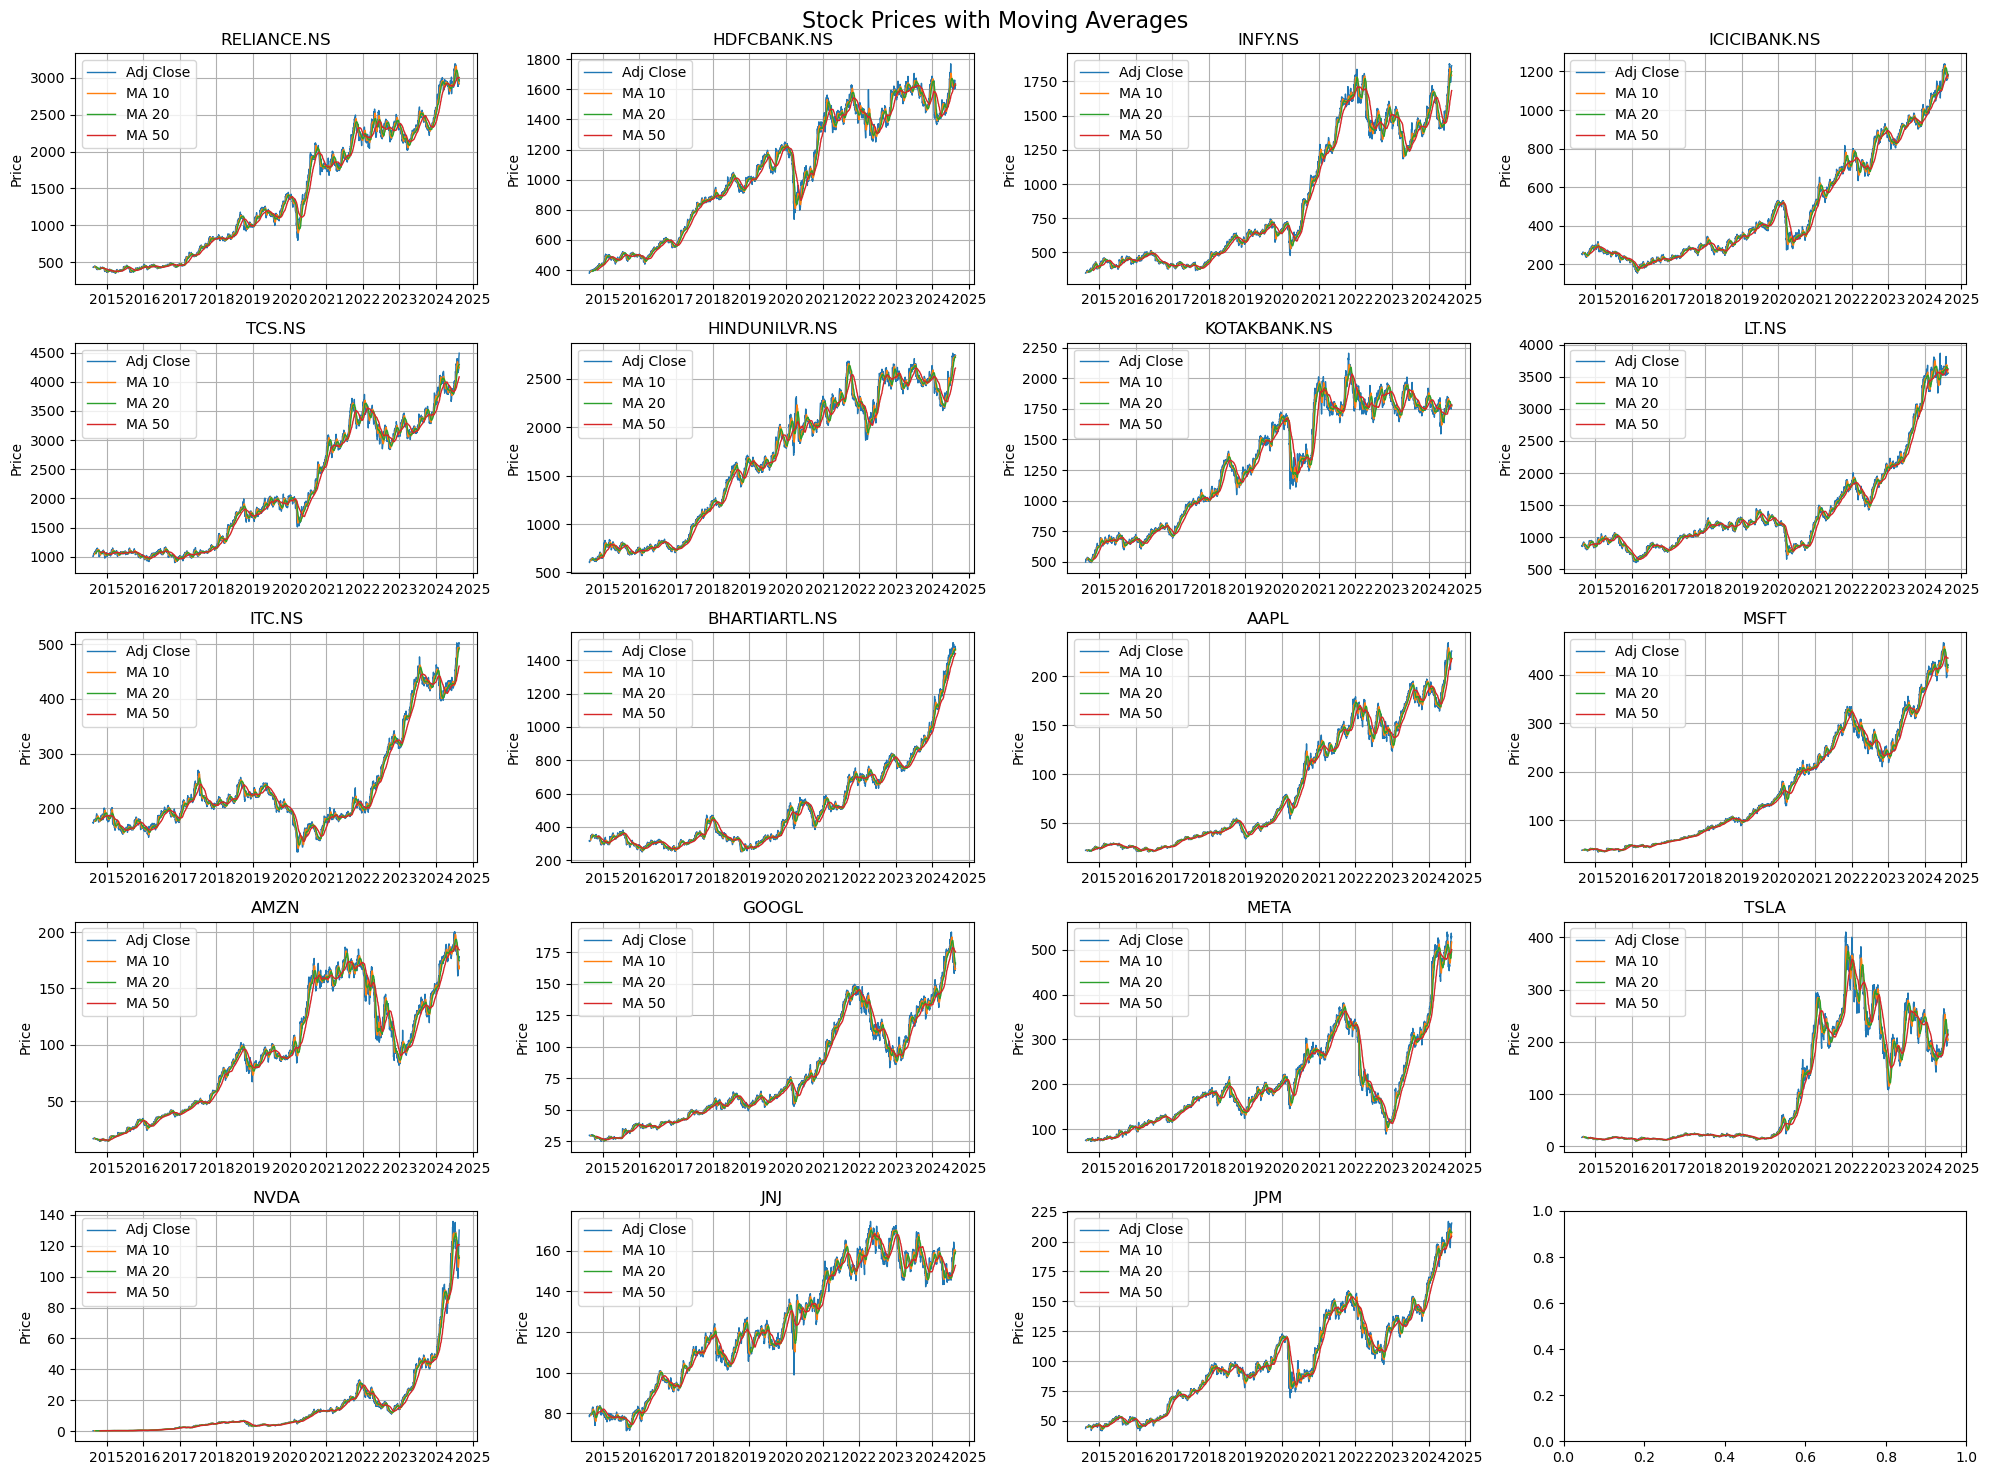

In [6]:
import matplotlib.pyplot as plt

# Define moving average periods
ma_day = [10, 20, 50]

# Calculate moving averages for each stock
stock_dfs = {}
for stock in all_stocks:  
    stock_df = df.loc[stock].copy()  # Create a copy of the DataFrame
    for ma in ma_day:
        column_name = f"MA for {ma} days"
        stock_df[column_name] = stock_df['Adj Close'].rolling(ma).mean()
    stock_dfs[stock] = stock_df  # Store the DataFrame in a dictionary

# Plot each stock's adjusted close price along with the moving averages
fig, axes = plt.subplots(nrows=5, ncols=4, figsize=(20, 15))
fig.suptitle('Stock Prices with Moving Averages', fontsize=16)

# Iterate through the stocks and plot them individually
for i, stock in enumerate(all_stocks):
    stock_df = stock_dfs[stock]
    row, col = divmod(i, 4)
    ax = axes[row, col]
    ax.plot(stock_df['Adj Close'], label='Adj Close', linewidth=1.0)
    ax.plot(stock_df['MA for 10 days'], label='MA 10', linewidth=1.0)
    ax.plot(stock_df['MA for 20 days'], label='MA 20', linewidth=1.0)
    ax.plot(stock_df['MA for 50 days'], label='MA 50', linewidth=1.0)
    ax.set_title(stock, fontsize=12)
    ax.set_ylabel('Price')
    ax.grid(True)
    ax.legend(loc='upper left')

# Adjust layout
plt.tight_layout()
plt.show()

What was the daily return of the stock on average?

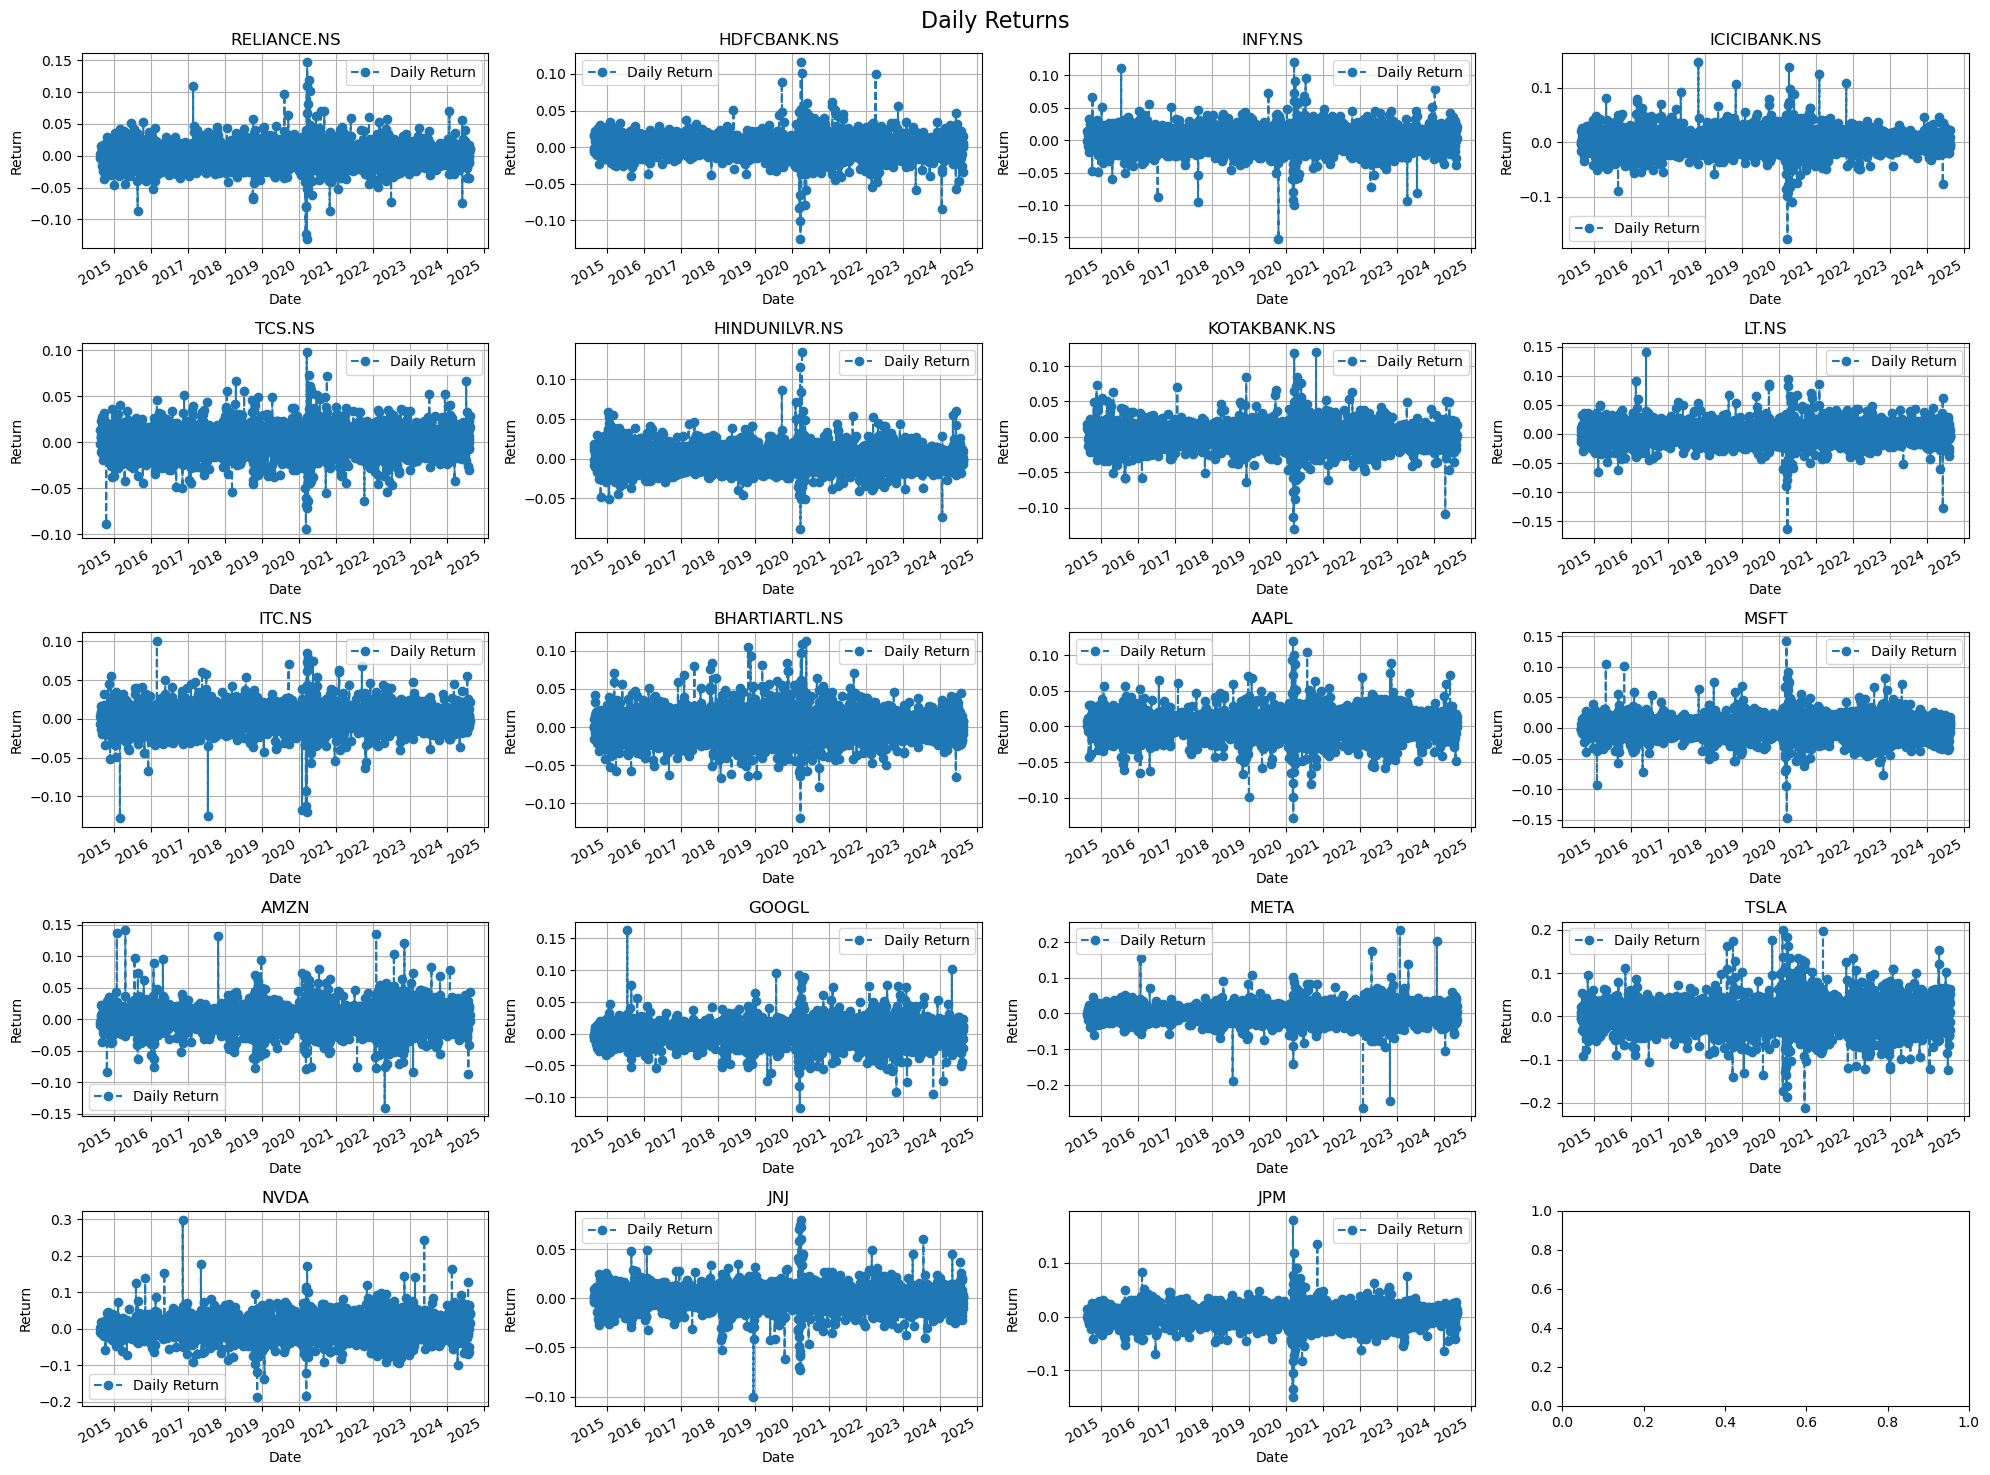

In [7]:
# Calculate daily returns for each stock
for stock in all_stocks:
    stock_df = stock_dfs[stock]
    stock_df['Daily Return'] = stock_df['Adj Close'].pct_change()

# Plot daily returns for each stock
fig, axes = plt.subplots(nrows=5, ncols=4, figsize=(20, 15))
fig.suptitle('Daily Returns', fontsize=16)

# Iterate through the stocks and plot them individually
for i, stock in enumerate(all_stocks):
    stock_df = stock_dfs[stock]
    row, col = divmod(i, 4)
    ax = axes[row, col]
    stock_df['Daily Return'].plot(ax=ax, legend=True, linestyle='--', marker='o')
    ax.set_title(stock, fontsize=12)
    ax.set_ylabel('Return')
    ax.grid(True)

# Adjust layout
plt.tight_layout()
plt.show()

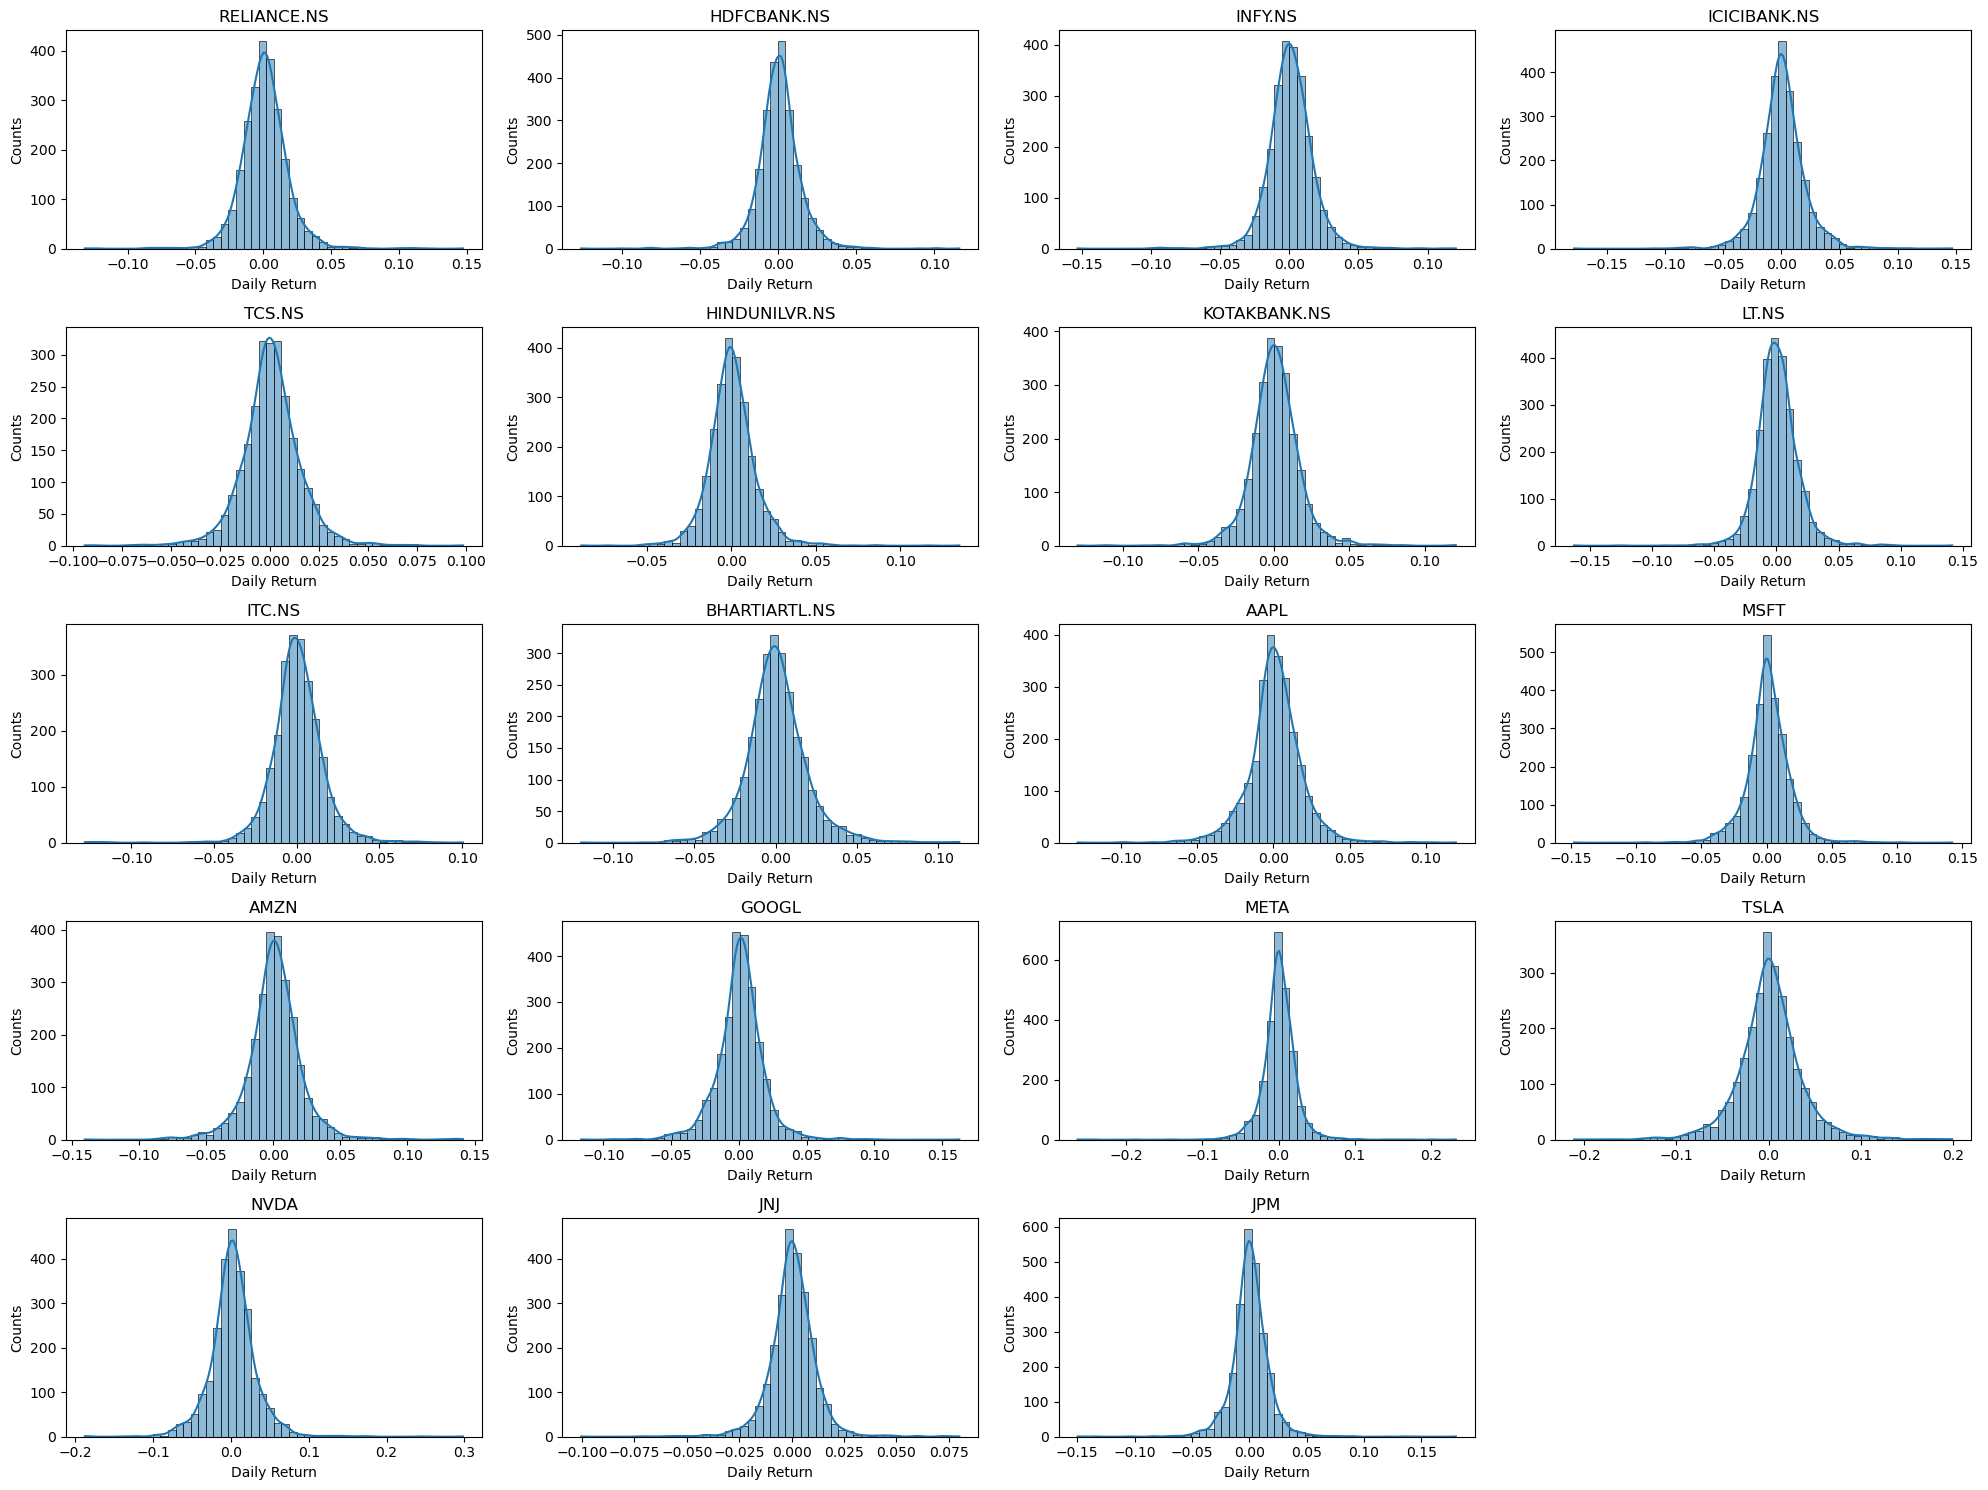

In [8]:
import seaborn as sns

plt.figure(figsize=(20, 15))

for i, stock in enumerate(all_stocks, 1):
    plt.subplot(5, 4, i)
    sns.histplot(stock_dfs[stock]['Daily Return'], bins=50, kde=True)
    plt.xlabel('Daily Return')
    plt.ylabel('Counts')
    plt.title(stock)

plt.tight_layout()
plt.show()